In [25]:
# %pip install seaborn

In [26]:
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F

import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.model.model import DeepSensorModel

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# filter DeprecationWarning from the IPython kernel
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel")

In [27]:
class Encoder(nn.Module):
    def __init__(self, x_dim, y_dim, encoder_dim, neurons, activation):
        super().__init__()
        self.neurons = neurons
        self.activation = activation
        self.input = nn.Linear(x_dim + y_dim, neurons[0])
        for i in range(len(neurons) - 1):
            setattr(self, f"layer{i}", nn.Linear(neurons[i], neurons[i + 1]))

        self.output = nn.Linear(neurons[-1], encoder_dim)

    def forward(self, context_x, context_y):
        x = torch.cat([context_x, context_y], dim=-1)
        x = self.activation(self.input(x))
        for i in range(len(self.neurons) - 1):
            x = self.activation(getattr(self, f"layer{i}")(x))

        x = self.output(x)
        return x.mean(dim=-2, keepdim=True)


class Decoder(nn.Module):
    def __init__(self, input_dim, encoder_dim, output_dim, neurons, activation):
        super().__init__()
        self.neurons = neurons
        self.activation = activation
        self.input = nn.Linear(input_dim + encoder_dim, neurons[0])
        for i in range(len(neurons) - 1):
            setattr(self, f"layer{i}", nn.Linear(neurons[i], neurons[i + 1]))

        self.mean = nn.Linear(neurons[-1], output_dim)
        self.log_std = nn.Linear(neurons[-1], output_dim)

    def forward(self, repr, target_x):
        repr = repr.repeat(1, target_x.shape[1], 1)
        x = torch.cat([repr, target_x], dim=-1)
        x = self.activation(self.input(x))
        for i in range(len(self.neurons) - 1):
            x = self.activation(getattr(self, f"layer{i}")(x))

        mean = self.mean(x)
        log_std = self.log_std(x)
        std = torch.exp(log_std) + 1e-10
        return mean, std


class CNP(nn.Module):
    def __init__(
        self,
        x_dim,
        y_dim,
        encoder_dim,
        encoder_neurons,
        decoder_neurons,
        activation,
    ):
        super().__init__()
        self.encoder = Encoder(x_dim, y_dim, encoder_dim, encoder_neurons, activation)
        self.decoder = Decoder(encoder_dim, encoder_dim, y_dim, decoder_neurons, activation)

    def forward(self, context_x, context_y, target_x):
        repr = self.encoder(context_x, context_y)
        mean, std = self.decoder(repr, target_x)
        return mean, std

## Load data

In [28]:
ds_list = []
for i in range(24):
    i = str(i).zfill(2)
    ds = xr.open_dataset(f"../datasets/era5/era5_2021_01_{i}-00.nc")
    ds_list.append(ds)

ds = xr.concat(ds_list, dim="time").sortby("time")[["tp"]]
ds

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 99, longitude: 108)
Coordinates:
  * longitude  (longitude) float32 -124.7 -124.6 -124.5 ... -114.2 -114.1 -114.0
  * latitude   (latitude) float32 42.13 42.03 41.93 41.83 ... 32.53 32.43 32.33
  * time       (time) time64[ns] 2021-01-01 ... 2021-01-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 nan nan ... 3.725e-09
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-20 19:05:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

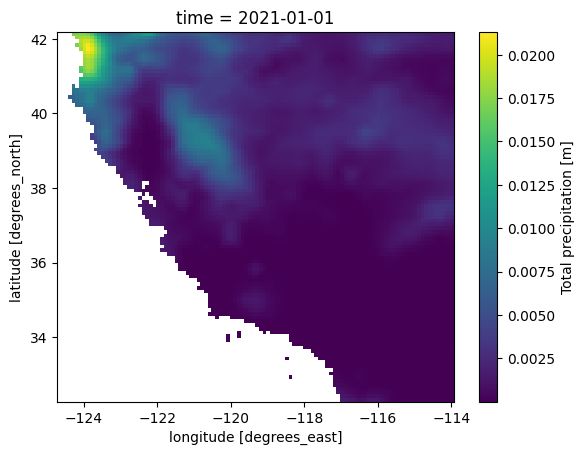

In [29]:
ds.tp.isel(time=0).plot()

In [20]:
# Normalise data
data_processor = DataProcessor(x1_name="latitude", x2_name="longitude")
processed_ds = data_processor(ds)
processed_ds

<xarray.Dataset>
Dimensions:  (time: 744, x1: 99, x2: 108)
Coordinates:
  * x2       (x2) float32 0.0 0.009345 0.01869 0.02804 ... 0.9813 0.9907 1.0
  * x1       (x1) float32 1.0 0.9898 0.9796 0.9694 ... 0.02051 0.01031 0.0
  * time     (time) time64[ns] 2021-01-01 ... 2021-01-31T23:00:00
Data variables:
    tp       (time, x1, x2) float32 nan nan nan nan ... -0.2466 -0.2466 -0.2466
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-20 19:05:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...